In [1]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pickle import load
from transformers import AutoTokenizer, RobertaTokenizer
from sklearn.metrics import confusion_matrix
from transformers import RobertaForSequenceClassification, AlbertForSequenceClassification, DistilBertForSequenceClassification
from sklearn.metrics import classification_report
from typing import List
import sys
sys.path.append('../..')
from data.datasets import get_data_loaders_with_chatgpt_annotated_data

/home/getzner/miniconda3/envs/tandic-training/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: j-getzner. Use `wandb login --relogin` to force relogin


In [11]:
DEFAULT_CONFIG = {
    # data details
    "data_dir": "../../../datasets", 
    "dataset_splits": [0.7, 0.9],

    # model details
    "model_name": "distilbert-base-uncased",
    "lr": 5e-5,
    "epochs": 30, 
    "patience": 10,
    "num_warmup_steps": 500,
    "batch_sizes": {
        "train": 16,
        "val": 64,
        "test": 64
    },
    # other details
    "device": 'cpu' if torch.cuda.is_available() else 'cpu',
    "initial_seed": 1,
    "num_seeds": 5,
    "checkpoints_dir": "training/results/checkpoints",
}
print("Using config:", DEFAULT_CONFIG)

Using config: {'data_dir': '../../../datasets', 'dataset_splits': [0.7, 0.9], 'model_name': 'distilbert-base-uncased', 'lr': 5e-05, 'epochs': 30, 'patience': 10, 'num_warmup_steps': 500, 'batch_sizes': {'train': 16, 'val': 64, 'test': 64}, 'device': 'cpu', 'initial_seed': 1, 'num_seeds': 5, 'checkpoints_dir': 'training/results/checkpoints'}


In [3]:
MODELS_LIB = {
    "albert-base-v2": AlbertForSequenceClassification,
    "distilbert-base-uncased": DistilBertForSequenceClassification,
    "roberta-base": RobertaForSequenceClassification
}

# Load Data

In [4]:
data_loaders, label_encoder, _  = get_data_loaders_with_chatgpt_annotated_data(DEFAULT_CONFIG, debug=False, inference=True)
data_loaders["test"].dataset.data.head()
# delete training folder in current directory
os.system("rm -rf training")


Number of classes: 75


Size of train_df: 31565
Size of val_df: 9018
Size of test_df: 4510


0

# Load Models

In [5]:
def load_trained_model(model_name, path_to_model_files):
    model = MODELS_LIB[model_name].from_pretrained(path_to_model_files, local_files_only=True).to(DEFAULT_CONFIG["device"])
    path_to_tokenizer = "/".join(path_to_model_files.split("/")[:-1])
    if model_name == "roberta-base":
        tokenizer = RobertaTokenizer.from_pretrained(path_to_tokenizer, local_files_only=True, use_fast=False)
    else:
        tokenizer = AutoTokenizer.from_pretrained(path_to_tokenizer, local_files_only=True)
    le = load(open(os.path.join(path_to_tokenizer,'label_encoder.pkl'), 'rb'))
    model.eval()
    return model, tokenizer, le

In [1]:
def test_models(model_name:str, models):
    predictions = {seed: [] for seed in models[model_name]}
    for seed in models[model_name]:
        model, _, le = load_trained_model(
            model_name,
            seed
        )   
        for batch in tqdm(data_loaders["train"]):
            batch = {k: v.to(DEFAULT_CONFIG["device"]) for k, v in batch.items()}
            with torch.no_grad():
                output = model(**batch)
                batch_predictions = torch.argmax(output.logits, dim=-1)
            for idx, pred in enumerate(batch_predictions.tolist()):
                predictions[seed].append({"y_hat_enc": pred, "y_enc": batch["labels"].flatten().tolist()[idx], })
        predictions[seed] = pd.DataFrame(predictions[seed])
        predictions[seed]["y_hat"] = le.inverse_transform(predictions[seed]["y_hat_enc"])
        predictions[seed]["y"] = le.inverse_transform(predictions[seed]["y_enc"])
    return predictions

In [7]:
ONE_SEED_ONLY = False

In [8]:
models = {}
checkpoints = [f for f in os.listdir('.') if os.path.isdir(f)]
for checkpoint in checkpoints:
    model_name = checkpoint.split(' ')[1][9:]
    seeds = [
        os.path.join('.', checkpoint, f)
        for f in os.listdir(os.path.join('.', checkpoint))
        if os.path.isdir(os.path.join('.', checkpoint, f))
    ]
    models[model_name] = seeds if not ONE_SEED_ONLY else seeds[:1]
models

{'distilbert-base-uncased': ['./2024-06-02 17:48:54-distilbert-base-uncased/seed_4',
  './2024-06-02 17:48:54-distilbert-base-uncased/seed_5',
  './2024-06-02 17:48:54-distilbert-base-uncased/seed_3',
  './2024-06-02 17:48:54-distilbert-base-uncased/seed_1',
  './2024-06-02 17:48:54-distilbert-base-uncased/seed_2'],
 'roberta-base': ['./2024-06-03 19:29:33-roberta-base/seed_4',
  './2024-06-03 19:29:33-roberta-base/seed_5',
  './2024-06-03 19:29:33-roberta-base/seed_3',
  './2024-06-03 19:29:33-roberta-base/seed_1',
  './2024-06-03 19:29:33-roberta-base/seed_2'],
 'albert-base-v2': ['./2024-06-03 19:29:33-albert-base-v2/seed_4',
  './2024-06-03 19:29:33-albert-base-v2/seed_5',
  './2024-06-03 19:29:33-albert-base-v2/seed_3',
  './2024-06-03 19:29:33-albert-base-v2/seed_1',
  './2024-06-03 19:29:33-albert-base-v2/seed_2']}

In [9]:
def get_results(model, df):
    performance = classification_report(df["y"],
                                        df["y_hat"],
                                        target_names=df["y"].unique(),
                                        zero_division=0.0,
                                        output_dict=True)
    performance = pd.DataFrame(performance).T.sort_values(by="f1-score",
                                                          ascending=True)
    performance_to_plot = performance.drop(["accuracy", "macro avg", "weighted avg"])
    performance_to_plot[["f1-score"]].plot(kind="barh", figsize=(10, 20))
    # add numbers to the plot
    for i, v in enumerate(performance_to_plot["f1-score"]):
        plt.text(v, i, f"{v:.2f}", va="center")
    plt.title(f"F1 performance for {model}")
    plt.show()
    cm = confusion_matrix(df["y"], df["y_hat"], labels=df["y"].unique())
    plt.figure(figsize=(30, 30))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                xticklabels=df["y"].unique(),
                yticklabels=df["y"].unique())
    plt.title(f"Confusion matrix for {model}")
    plt.show()
    plt.figure(figsize=(10, 10))
    sns.set_theme(style="whitegrid")
    sns.scatterplot(data=performance_to_plot, x="f1-score", y="support")
    sns.scatterplot(data=performance_to_plot, x="recall", y="support")
    sns.scatterplot(data=performance_to_plot, x="precision", y="support")
    plt.legend(["f1-score", "recall", "precision"])
    plt.title(f"Performance metrics for {model}")
    plt.xlabel("Metric")
    plt.ylabel("Support")
    plt.show()
    return performance

# Distilbert

In [ ]:
predictions_distilbert = test_models("distilbert-base-uncased", models)
predictions_distilbert = pd.concat([predictions_distilbert[seed] for seed in predictions_distilbert], ignore_index=True)


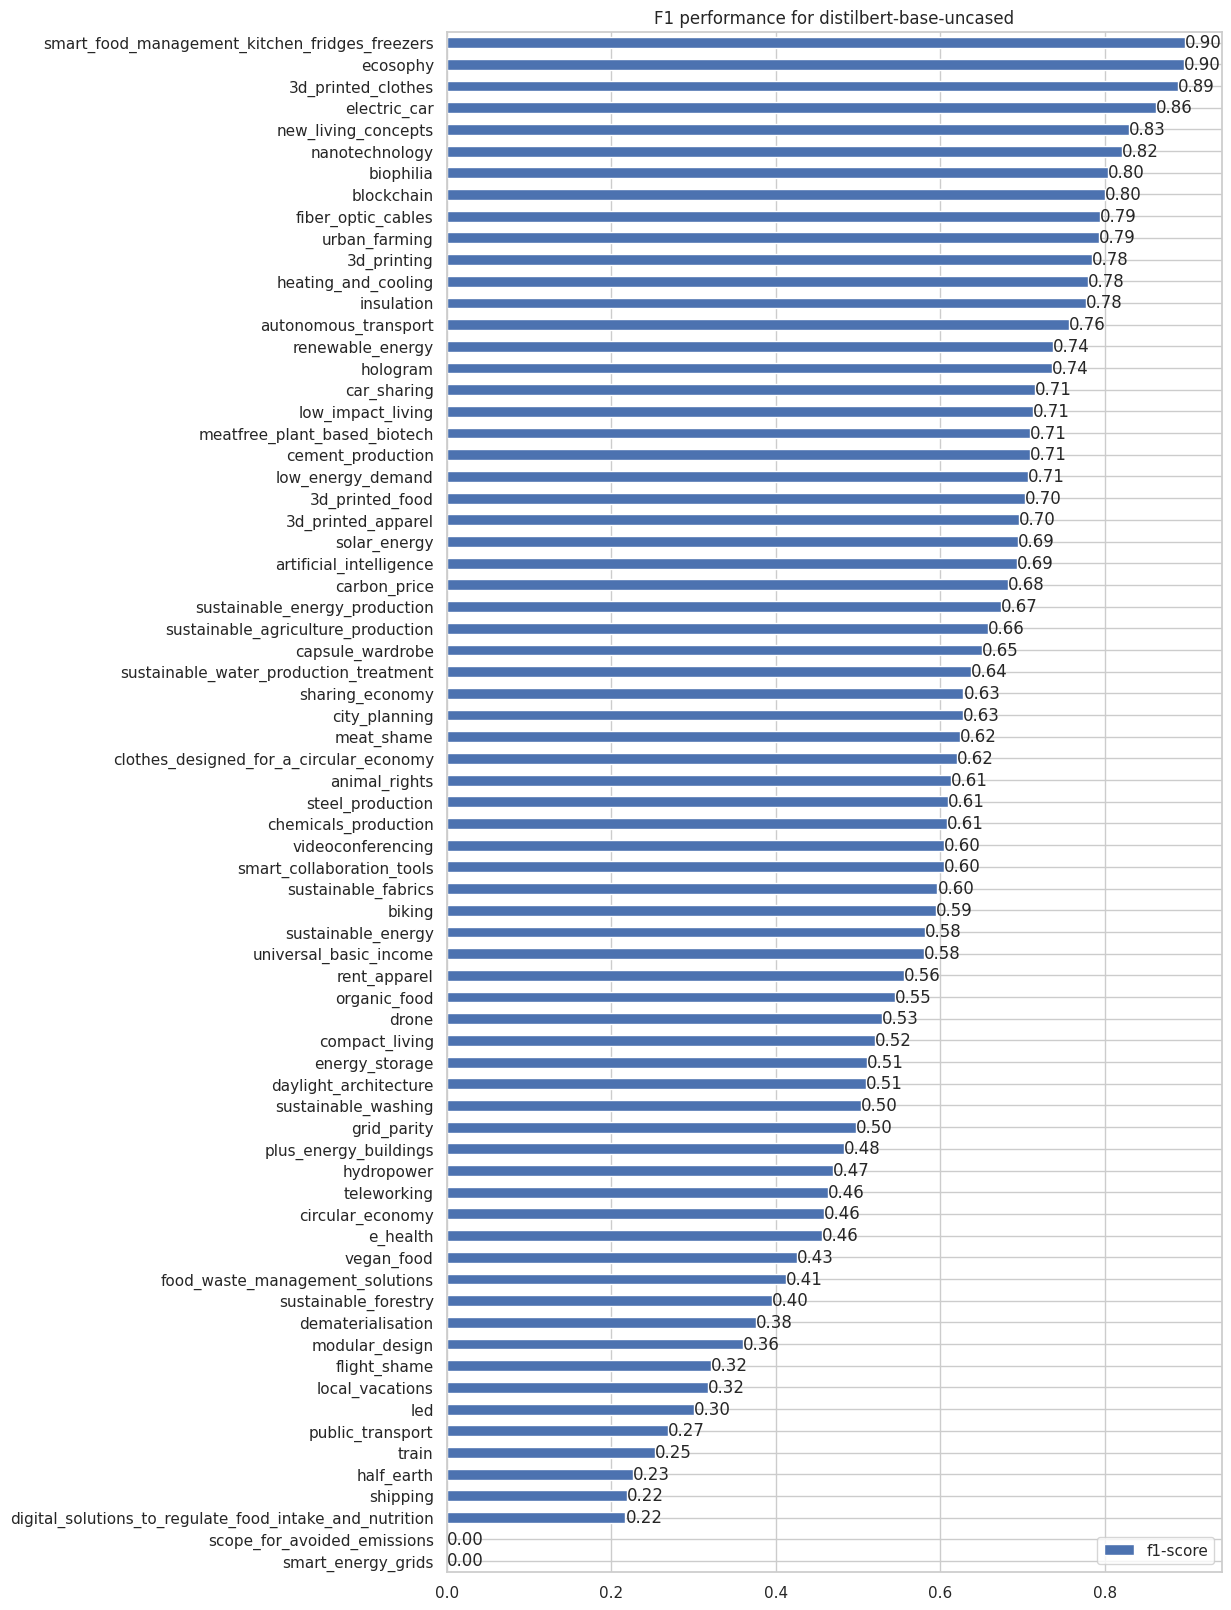

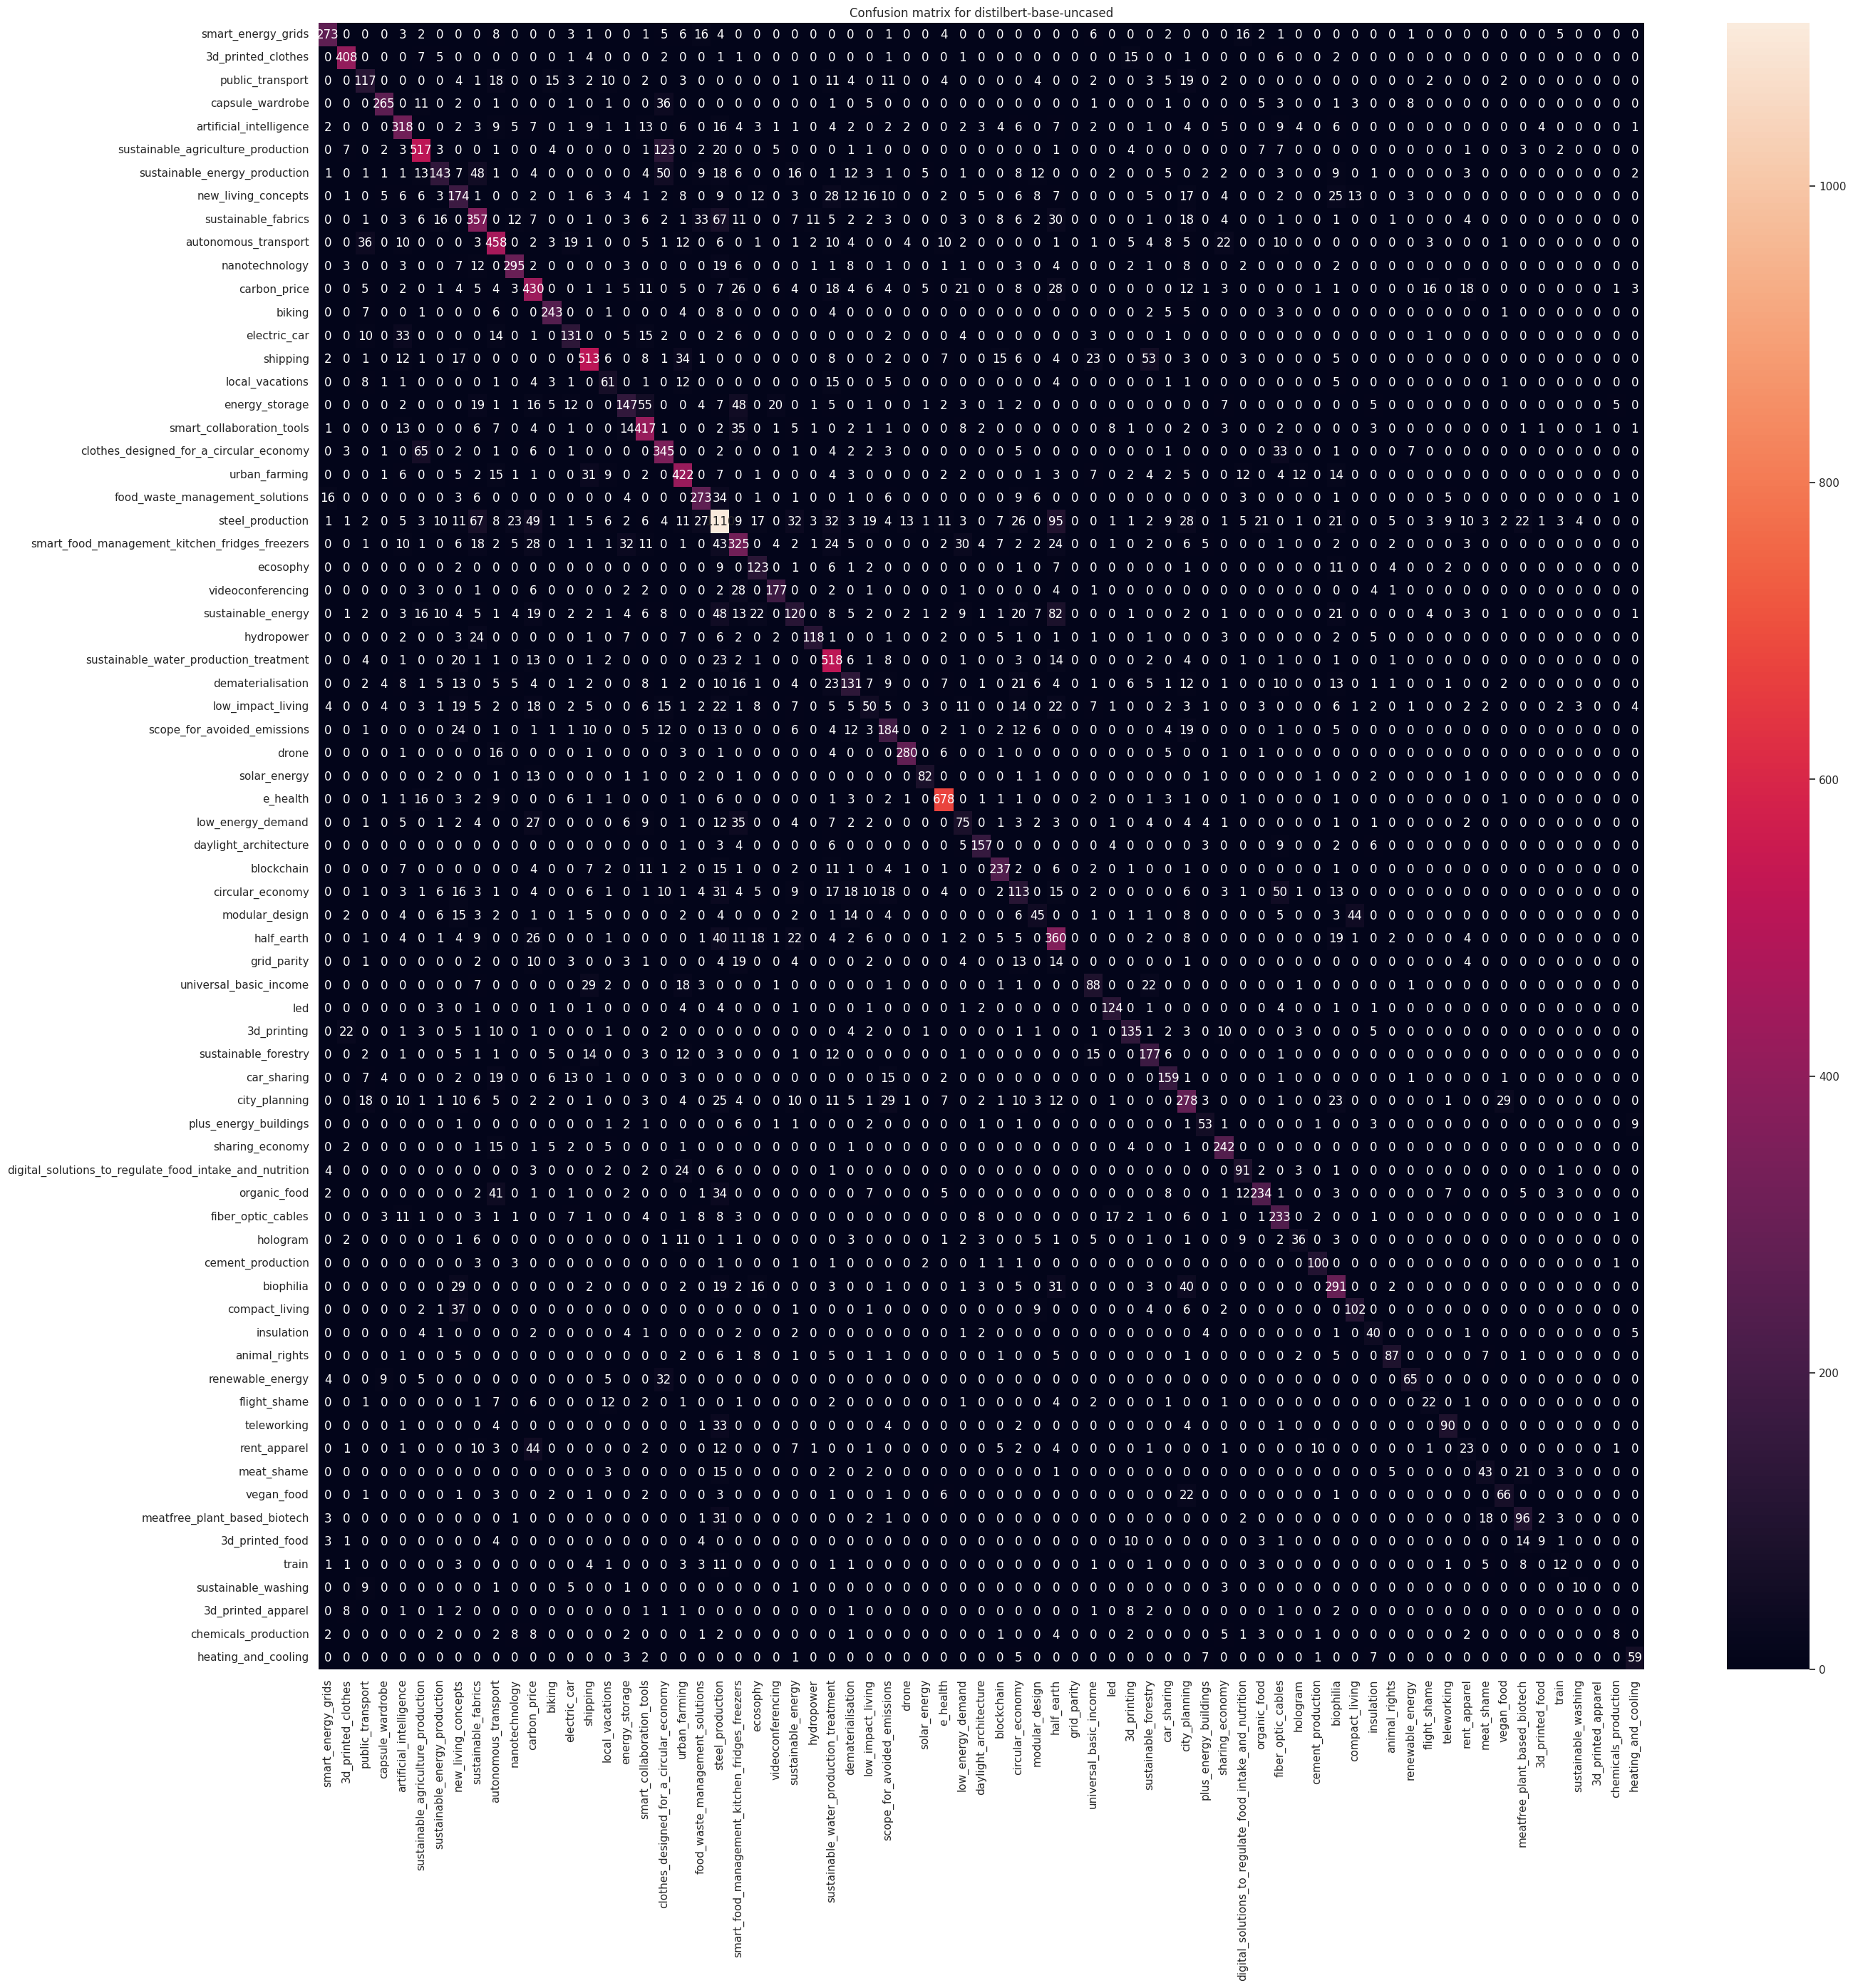

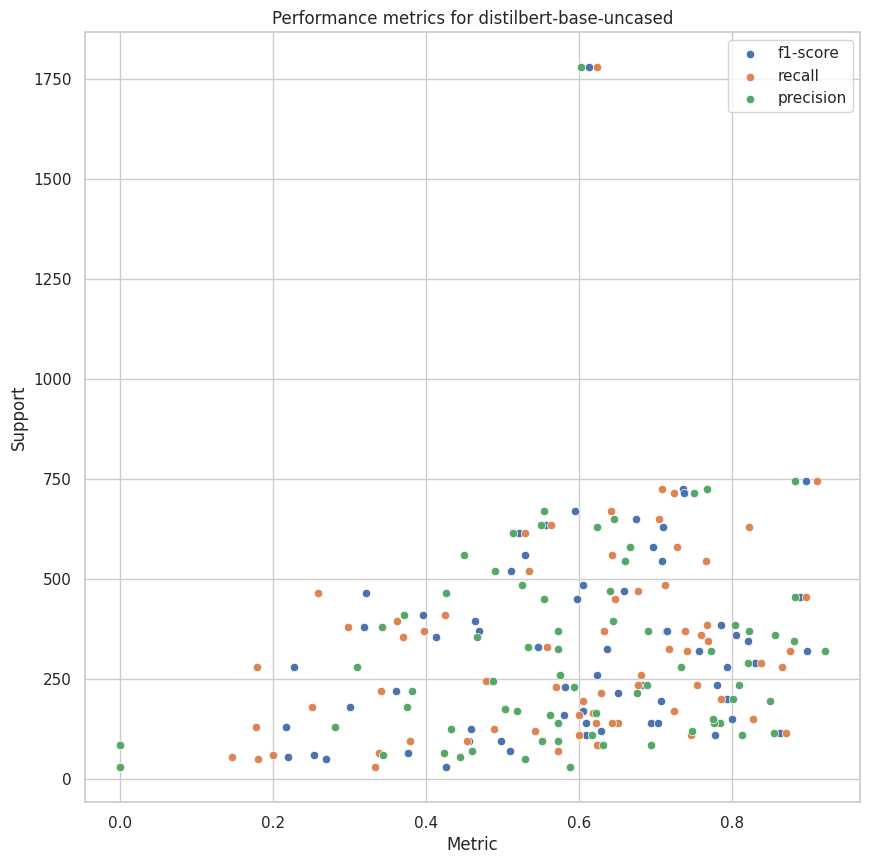

In [21]:
performance = get_results("distilbert-base-uncased", predictions_distilbert)

In [28]:
# print the full performance table, its not showing all the rows when printed
pd.set_option('display.max_rows', None)
performance.sort_values(by="f1-score", ascending=False)

,precision,recall,f1-score,support
smart_food_management_kitchen_fridges_freezers,0.921053,0.875000,0.897436,320.000000
ecosophy,0.881664,0.910067,0.895641,745.000000
3d_printed_clothes,0.881210,0.896703,0.888889,455.000000
electric_car,0.854701,0.869565,0.862069,115.000000
new_living_concepts,0.820946,0.837931,0.829352,290.000000
nanotechnology,0.880399,0.768116,0.820433,345.000000
biophilia,0.855799,0.758333,0.804124,360.000000
blockchain,0.775000,0.826667,0.800000,150.000000
fiber_optic_cables,0.733333,0.864286,0.793443,280.000000
urban_farming,0.801020,0.785000,0.792929,200.000000
